# This code is to analysis the gathered data of each Model

## Import the lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## find the data path

In [2]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'ModelsData')

## load all the model data

In [3]:
alexnet_data_folder = os.path.join(data_path, 'alexnet')

print(alexnet_data_folder)

/Users/dtjgp/Projects/GreenAI/3080/ModelsData/alexnet


## load the interpolate function

In [4]:
def integrate_power_over_interval(samples, start_time, end_time):
    # 假定 samples是按时间升序排序的 (t, p)
    # 若未排序，请先排序:
    # samples = sorted(samples, key=lambda x: x[0])
    
    def interpolate(samples, target_time):
        # 在 samples 中找到 target_time 左右最近的两个点，并进行线性插值
        # 若 target_time 恰好等于某个样本点时间，直接返回该点功率
        # 若无法找到两侧点（如 target_time在样本时间轴外），根据情况返回None或边界点
        n = len(samples)
        if n == 0:
            return None
        # 若 target_time 小于第一个样本点时间，无法向左插值，这里直接返回第一个点的功率值(或None)
        if target_time <= samples[0][0]:
            # 简化处理：返回最早样本点的功率（或None）
            return samples[0][1]
        # 若 target_time 大于最后一个样本点时间，无法向右插值，返回最后一个点的功率（或None）
        if target_time >= samples[-1][0]:
            return samples[-1][1]

        # 否则，在中间插值
        # 使用二分查找快速定位
        import bisect
        times = [t for t, _ in samples]
        pos = bisect.bisect_left(times, target_time)
        # pos是使times保持有序插入target_time的位置
        # 因为target_time不在已有样本点中，pos不会越界且pos>0且pos<n
        t1, p1 = samples[pos-1]
        t2, p2 = samples[pos]
        # 线性插值： p = p1 + (p2 - p1)*((target_time - t1)/(t2 - t1))
        ratio = (target_time - t1) / (t2 - t1)
        p = p1 + (p2 - p1)*ratio
        return p

    # 从原始 samples 中筛选出位于[start_time, end_time]内的点
    filtered = [(t, p) for t, p in samples if start_time <= t <= end_time]

    # 如果不足2个点，则尝试使用插值
    if len(filtered) < 2:
        # 无论如何都需要在边界处插值出两个点(起码start和end)
        start_power = interpolate(samples, start_time)
        end_power = interpolate(samples, end_time)

        # 如果从样本中无法插值出任何有意义的点（比如samples为空或无法插值），返回0.0
        if start_power is None or end_power is None:
            return 0.0

        # 将插值的边界点加入到 filtered
        # 注意：如果filtered中有一个点在区间内，我们也需要确保边界有两点以上
        # 例如filtered只有一个点在中间，则需要在start和end插值点全部加入。
        # 若filtered为空，则只用start/end两点插值点求积分
        new_filtered = [(start_time, start_power)] + filtered + [(end_time, end_power)]
        # 确保按时间排序
        new_filtered.sort(key=lambda x: x[0])
        filtered = new_filtered

    # 正常积分计算
    if len(filtered) < 2:
        # 经过插值仍不够，返回0
        return 0.0

    total_energy = 0.0
    for i in range(len(filtered)-1):
        t1, p1 = filtered[i]
        t2, p2 = filtered[i+1]
        dt = t2 - t1
        avg_p = (p1 + p2)/2.0
        total_energy += avg_p * dt

    return total_energy

## AlexNet

### find the data path contents

In [5]:
# show the files in the folder 
for file in os.listdir(alexnet_data_folder):
    print(file)

forward.npy
optimize.npy
backward.npy
to_device.npy
energy_consumption_file
loss.npy


In [9]:
# load the csv files 
energy_data = pd.read_csv(os.path.join(alexnet_data_folder, 'energy_consumption_file.csv'))

# load the npy files
to_device = np.load(os.path.join(alexnet_data_folder, 'to_device.npy'), allow_pickle=True)
forward = np.load(os.path.join(alexnet_data_folder, 'forward.npy'), allow_pickle=True)
loss = np.load(os.path.join(alexnet_data_folder, 'loss.npy'), allow_pickle=True)
backward = np.load(os.path.join(alexnet_data_folder, 'backward.npy'), allow_pickle=True)
optimize = np.load(os.path.join(alexnet_data_folder, 'optimize.npy'), allow_pickle=True)

In [10]:
# show the shape of the npy files
print(to_device.shape, forward.shape, loss.shape, backward.shape, optimize.shape)

(2, 235, 2) (2, 235, 2) (2, 235, 2) (2, 235, 2) (2, 235, 2)


In [11]:
# create energy consumption data to save each step energy consumption
# use the ndarray to save the data, the shape is the same as the original data with the shape[2] changed to 3
# the first two value is the start time and end time, the third value is the energy consumption
to_device_energy = np.zeros((to_device.shape[0], to_device.shape[1], 3))
forward_energy = np.zeros((forward.shape[0], forward.shape[1], 3))
loss_energy = np.zeros((loss.shape[0], loss.shape[1], 3))
backward_energy = np.zeros((backward.shape[0], backward.shape[1], 3))
optimize_energy = np.zeros((optimize.shape[0], optimize.shape[1], 3))

In [12]:
# calculate the energy consumption for each step, 
# each runs 2 epochs, the first value of the shape is the epoch number
# the second value is number of batches
for epoch in range(to_device.shape[0]):
    for batch in range(to_device.shape[1]):
        to_device_energy[epoch][batch][0] = to_device[epoch][batch][0]
        to_device_energy[epoch][batch][1] = to_device[epoch][batch][1]
        to_device_energy[epoch][batch][2] = integrate_power_over_interval(energy_data.values, to_device[epoch][batch][0], to_device[epoch][batch][1])

        forward_energy[epoch][batch][0] = forward[epoch][batch][0]
        forward_energy[epoch][batch][1] = forward[epoch][batch][1]
        forward_energy[epoch][batch][2] = integrate_power_over_interval(energy_data.values, forward[epoch][batch][0], forward[epoch][batch][1])

        loss_energy[epoch][batch][0] = loss[epoch][batch][0]
        loss_energy[epoch][batch][1] = loss[epoch][batch][1]
        loss_energy[epoch][batch][2] = integrate_power_over_interval(energy_data.values, loss[epoch][batch][0], loss[epoch][batch][1])

        backward_energy[epoch][batch][0] = backward[epoch][batch][0]
        backward_energy[epoch][batch][1] = backward[epoch][batch][1]
        backward_energy[epoch][batch][2] = integrate_power_over_interval(energy_data.values, backward[epoch][batch][0], backward[epoch][batch][1])

        optimize_energy[epoch][batch][0] = optimize[epoch][batch][0]
        optimize_energy[epoch][batch][1] = optimize[epoch][batch][1]
        optimize_energy[epoch][batch][2] = integrate_power_over_interval(energy_data.values, optimize[epoch][batch][0], optimize[epoch][batch][1])

In [13]:
print(to_device_energy[0][0][0], to_device_energy[0][0][1], to_device_energy[0][0][2])
# print(forward[0][0][0], forward[0][0][1], forward_energy[0][0][2])

1733695889.32073 1733695889.3324487 0.5391497506643989


In [14]:
# Set the display format for floating-point numbers to avoid scientific notation
pd.options.display.float_format = '{:.6f}'.format

def label_energy_consumption(energy_data, to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    # Create a copy of the energy_data dataframe to avoid modifying the original
    labeled_energy_data = energy_data.copy()
    
    # Initialize a new column for the step labels
    labeled_energy_data['step'] = 'idle'
    
    # Define a helper function to label the steps
    def label_steps(energy_data, step_energy, step_name):
        for epoch in range(step_energy.shape[0]):
            for batch in range(step_energy.shape[1]):
                start_time = step_energy[epoch][batch][0]
                end_time = step_energy[epoch][batch][1]
                mask = (energy_data['timestamp'] >= start_time) & (energy_data['timestamp'] <= end_time)
                labeled_energy_data.loc[mask, 'step'] = step_name
    
    # Label each step
    label_steps(labeled_energy_data, to_device_energy, 'to_device')
    label_steps(labeled_energy_data, forward_energy, 'forward')
    label_steps(labeled_energy_data, loss_energy, 'loss')
    label_steps(labeled_energy_data, backward_energy, 'backward')
    label_steps(labeled_energy_data, optimize_energy, 'optimize')
    
    return labeled_energy_data

# Use the function to label the energy consumption data
labeled_energy_data = label_energy_consumption(energy_data, to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
print(labeled_energy_data.head())

          timestamp  power_in_watts  step
0 1733695888.921229       21.700000  idle
1 1733695889.004280       21.700000  idle
2 1733695889.067717       24.967000  idle
3 1733695889.106929       24.967000  idle
4 1733695889.118079       24.967000  idle


In [15]:
# save the file to the folder
labeled_energy_data.to_csv(os.path.join(alexnet_data_folder, 'labeled_energy_data.csv'), index=False)

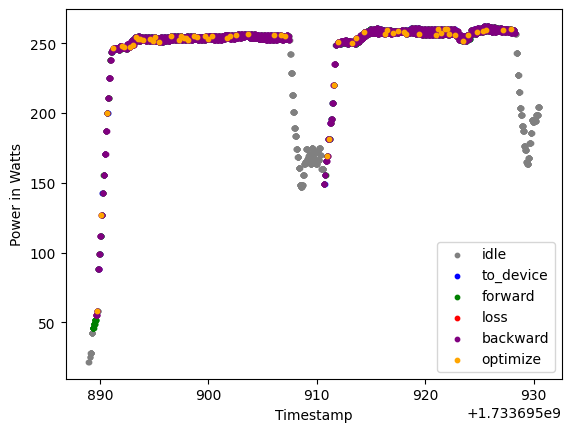

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a color map for the steps
step_colors = {
    'idle': 'gray',
    'to_device': 'blue',
    'forward': 'green',
    'loss': 'red',
    'backward': 'purple',
    'optimize': 'orange'
}

# Plot the data
fig, ax = plt.subplots()
for step in labeled_energy_data['step'].unique():
    step_data = labeled_energy_data[labeled_energy_data['step'] == step]
    ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step, s=10)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Power in Watts')
ax.legend()
plt.show()


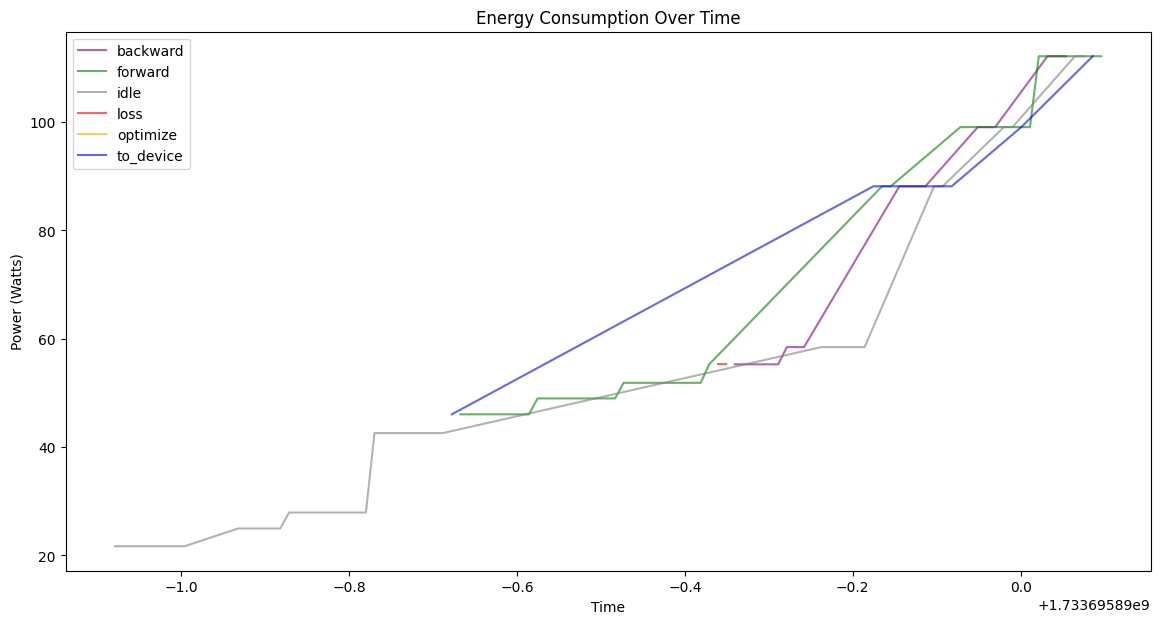

In [19]:
plot_energy_consumption(labeled_energy_data[:100])